<a href="https://colab.research.google.com/github/Evolved360/Neural-Inc/blob/main/Feature_engineering_and_featurization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

!pip install CBFV
!pip install matminer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 539.2/539.2 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 669.1/669.1 kB 26.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 73.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.9/67.9 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 86.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 87.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 332.3/332.3 kB 35.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 561.4/561.4 kB 40.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.8/117.8 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import normalize, StandardScaler
import CBFV
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from CBFV.composition import generate_features as gf
import matplotlib.pyplot as plt
import warnings
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.decomposition import PCA
warnings.filterwarnings('ignore')

In [23]:
# Import all data extracted
Li_data = pd.read_csv('Li_data.csv')
Ca_data = pd.read_csv('Ca_data.csv')
Mg_data = pd.read_csv('Mg_data.csv')
Cs_data = pd.read_csv('Cs_data.csv')
K_data = pd.read_csv('K_data.csv')
Na_data = pd.read_csv('Na_data.csv')
Al_data = pd.read_csv('Al_data.csv')
Rb_data = pd.read_csv('Rb_data.csv')
Y_data = pd.read_csv('Y_data.csv')
Zn_data = pd.read_csv('Zn_data.csv')

In [24]:
#
battery_data = pd.concat([Li_data, Ca_data, Mg_data, Cs_data, K_data, Na_data, Al_data, Rb_data, Y_data, Zn_data])
battery_data.reset_index(drop = True, inplace = True)
battery_data.to_csv('battery_data.csv', index=False)

In [25]:
battery_data.head()

,battery_type,battery_id,thermo_type,battery_formula,working_ion,num_steps,max_voltage_step,last_updated,framework,framework_formula,...,volume_charge,volume_discharge,band_gap_charge,band_gap_discharge,energy_above_hull_charge,energy_above_hull_discharge,ordering_charge,ordering_discharge,density_atomic_charge,density_atomic_discharge
0,NaN,mp-757871_Li,NaN,Li2-4CoNi3O8,Li,2,0.221134,2022-06-28 03:50:55.322,Co1 Ni3 O8,CoNi3O8,...,136.932319,138.120131,0.0000,0.0728,0.033696,0.005797,FM,FiM,9.780880,8.632508
1,NaN,mp-755220_Li,NaN,Li3-4CrNi3O8,Li,1,0.000000,2022-06-28 03:50:55.322,Cr1 Ni3 O8,CrNi3O8,...,141.035503,140.519241,0.0000,0.0000,0.089458,0.038080,FM,FiM,9.402367,8.782453
2,NaN,mp-762224_Li,NaN,Li0-4Cu3Sb(PO4)4,Li,1,0.000000,2022-06-28 03:50:55.322,Cu3 Sb1 P4 O16,Cu3Sb(PO4)4,...,288.123451,310.859846,0.0022,0.0000,0.069619,0.072188,FiM,FM,12.005144,11.102137
3,NaN,mp-759472_Li,NaN,Li1-2Cu(HO)4,Li,1,0.000000,2022-06-28 03:50:55.322,Cu1 H4 O4,Cu(HO)4,...,352.119752,343.634432,1.4109,0.0000,0.081335,0.079091,NM,FM,8.802994,7.809873
4,NaN,mp-772496_Li,NaN,Li0-4Mn3CuNi2(PO4)6,Li,1,0.000000,2022-06-28 03:50:55.322,Mn3 Cu1 Ni2 P6 O24,Mn3CuNi2(PO4)6,...,430.027099,460.683513,0.0000,0.0000,0.046100,0.083395,FM,FiM,11.945197,11.517088


In [26]:
# Assign redundant columns to a variable
irrelevant_columns = ['battery_type', 'battery_id', 'thermo_type', 'last_updated', 'id_charge', 'id_discharge', 'host_structure', 'adj_pairs',
                     'material_ids', 'entries_composition_summary', 'electrode_object', 'fields_not_requested', 'elements', 'framework', 'warnings',
                     'formula_charge', 'formula_discharge', 'formula_anonymous', 'chemsys', 'battery_formula']

In [27]:
# Remove redundancy
battery_data.drop(irrelevant_columns, axis=1, inplace=True)

In [28]:
battery_data.head()

,working_ion,num_steps,max_voltage_step,framework_formula,nelements,max_delta_volume,average_voltage,capacity_grav,capacity_vol,energy_grav,...,volume_charge,volume_discharge,band_gap_charge,band_gap_discharge,energy_above_hull_charge,energy_above_hull_discharge,ordering_charge,ordering_discharge,density_atomic_charge,density_atomic_discharge
0,Li,2,0.221134,CoNi3O8,3,0.008674,3.645088,137.171754,644.437651,500.003153,...,136.932319,138.120131,0.0000,0.0728,0.033696,0.005797,FM,FiM,9.780880,8.632508
1,Li,1,0.000000,CrNi3O8,3,0.003674,3.555958,69.825436,316.717528,248.296319,...,141.035503,140.519241,0.0000,0.0000,0.089458,0.038080,FM,FiM,9.402367,8.782453
2,Li,1,0.000000,Cu3Sb(PO4)4,4,0.078912,3.637514,148.887306,572.668449,541.579600,...,288.123451,310.859846,0.0022,0.0000,0.069619,0.072188,FiM,FM,12.005144,11.102137
3,Li,1,0.000000,Cu(HO)4,3,0.024693,2.901634,184.256618,518.049443,534.645191,...,352.119752,343.634432,1.4109,0.0000,0.081335,0.079091,NM,FM,8.802994,7.809873
4,Li,1,0.000000,Mn3CuNi2(PO4)6,5,0.071289,3.757691,113.645161,386.424999,427.043409,...,430.027099,460.683513,0.0000,0.0000,0.046100,0.083395,FM,FiM,11.945197,11.517088


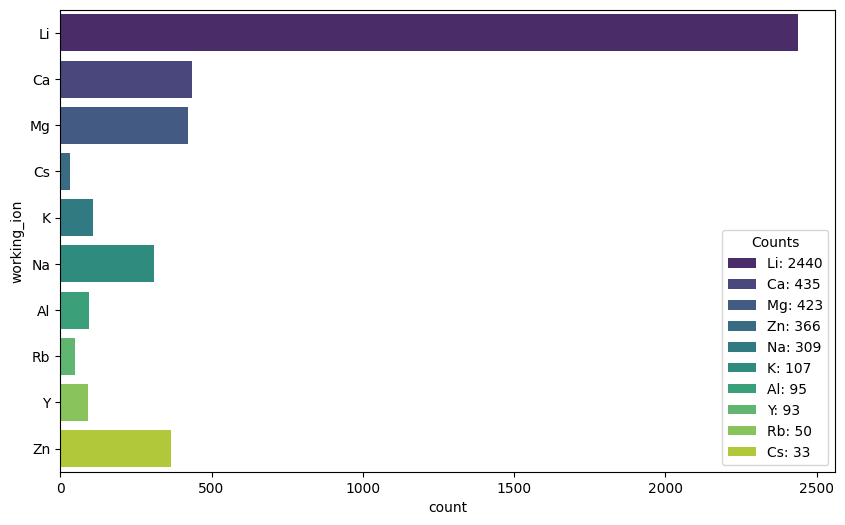

In [29]:
plt.figure(figsize=(10, 6))
ax = sns.countplot(battery_data['working_ion'], palette='viridis')

# Get the unique categories and their counts
categories = battery_data['working_ion'].value_counts().index.tolist()
counts = battery_data['working_ion'].value_counts().tolist()

# Create custom legend
legend_labels = [f'{cat}: {count}' for cat, count in zip(categories, counts)]
ax.legend(handles=ax.patches, labels=legend_labels, title='Counts')

<Axes: >

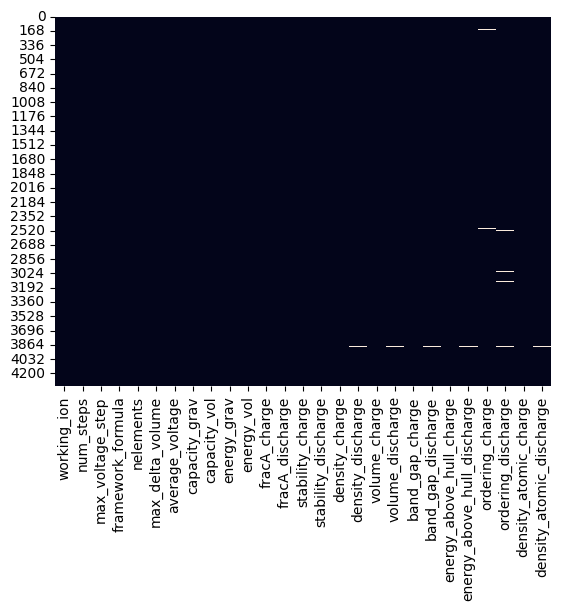

In [30]:
# Display battery data information
sns.heatmap(battery_data.isnull(), cbar=False)

In [31]:
#
battery_data.dropna(inplace=True)
battery_data.reset_index(drop = True, inplace = True)

<Axes: >

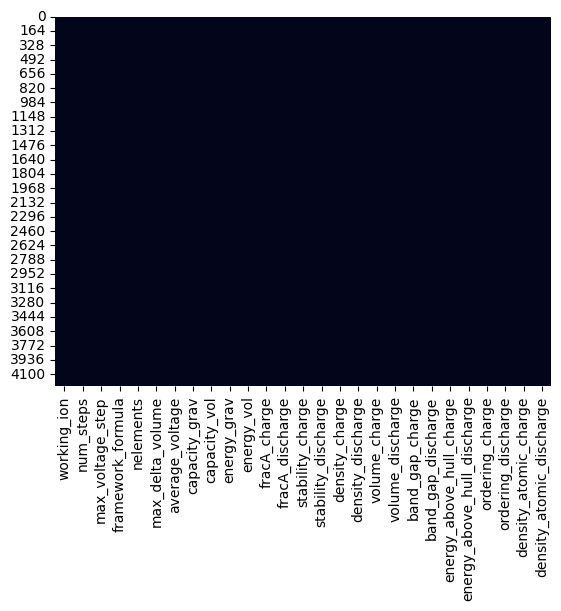

In [32]:
sns.heatmap(battery_data.isnull(), cbar=False)

In [33]:
battery_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4238 entries, 0 to 4237
Data columns (total 27 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   working_ion                  4238 non-null   object 
 1   num_steps                    4238 non-null   int64  
 2   max_voltage_step             4238 non-null   float64
 3   framework_formula            4238 non-null   object 
 4   nelements                    4238 non-null   int64  
 5   max_delta_volume             4238 non-null   float64
 6   average_voltage              4238 non-null   float64
 7   capacity_grav                4238 non-null   float64
 8   capacity_vol                 4238 non-null   float64
 9   energy_grav                  4238 non-null   float64
 10  energy_vol                   4238 non-null   float64
 11  fracA_charge                 4238 non-null   float64
 12  fracA_discharge              4238 non-null   float64
 13  stability_charge  

# **FEATURIZATION**

In [34]:
#Replace catergorical data in one hot style##
battery_data = pd.get_dummies(battery_data, columns=['working_ion'], prefix = ['working_ion'], dtype = float)
battery_data = pd.get_dummies(battery_data, columns=['ordering_charge'], prefix = ['ordering_charge'], dtype = float)
battery_data = pd.get_dummies(battery_data, columns=['ordering_discharge'], prefix = ['ordering_discharge'], dtype = float)

In [35]:
battery_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4238 entries, 0 to 4237
Data columns (total 44 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   num_steps                    4238 non-null   int64  
 1   max_voltage_step             4238 non-null   float64
 2   framework_formula            4238 non-null   object 
 3   nelements                    4238 non-null   int64  
 4   max_delta_volume             4238 non-null   float64
 5   average_voltage              4238 non-null   float64
 6   capacity_grav                4238 non-null   float64
 7   capacity_vol                 4238 non-null   float64
 8   energy_grav                  4238 non-null   float64
 9   energy_vol                   4238 non-null   float64
 10  fracA_charge                 4238 non-null   float64
 11  fracA_discharge              4238 non-null   float64
 12  stability_charge             4238 non-null   float64
 13  stability_discharg

In [36]:
sample_data = battery_data[['framework_formula','average_voltage' ]]

In [37]:
sample_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4238 entries, 0 to 4237
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   framework_formula  4238 non-null   object 
 1   average_voltage    4238 non-null   float64
dtypes: float64(1), object(1)
memory usage: 66.3+ KB


In [38]:
# prompt: Using dataframe sample_data: rename formula charge

sample_data.rename(columns={'framework_formula': 'formula',
                            'average_voltage': 'target'}, inplace=True)

In [39]:

sample_data.head()

,formula,target
0,CoNi3O8,3.645088
1,CrNi3O8,3.555958
2,Cu3Sb(PO4)4,3.637514
3,Cu(HO)4,2.901634
4,Mn3CuNi2(PO4)6,3.757691


In [40]:
sample_data.to_csv('sample_data.csv', index=False)

In [41]:
class Featurize():
    def __init__(self, data_path, scale=True, save=True):
        self.data_path = data_path
        self.scale = scale
        self.save = save
        self.get_xy()

    def get_xy(self):
        df = pd.read_csv(self.data_path)
        df.columns = ['formula', 'target']
        self.df = df
        X, y, formulae, skipped = gf(df, elem_prop='oliynyk')
        self.columns = X.columns
        self.X = X
        self.y = y
        if self.scale:
            self.scaler = StandardScaler()
            self.X = normalize(self.scaler.fit_transform(X))
        self.formula = formulae
        self.skipped = skipped


train_file = 'sample_data.csv'

# create a model (featurization of train data here)
feats = Featurize(train_file, scale=True, save=True)

Processing Input Data: 100%|██████████| 4238/4238 [00:00<00:00, 16724.97it/s]


	Featurizing Compositions...


Assigning Features...: 100%|██████████| 4238/4238 [00:00<00:00, 8005.88it/s]


	Creating Pandas Objects...


In [42]:
featurized_data = pd.DataFrame(feats.X, columns=feats.columns)
featurized_data.reset_index()
featurized_data.to_csv('cbfv_data.csv', index=False)

In [43]:
battery_data = pd.concat([battery_data, featurized_data], axis = 1)

In [44]:
battery_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4238 entries, 0 to 4237
Columns: 308 entries, num_steps to mode_Cohesive_energy
dtypes: float64(305), int64(2), object(1)
memory usage: 10.0+ MB


In [45]:
battery_data.drop(['framework_formula'], axis=1, inplace=True)

In [46]:
battery_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4238 entries, 0 to 4237
Columns: 307 entries, num_steps to mode_Cohesive_energy
dtypes: float64(305), int64(2)
memory usage: 9.9 MB


# PRINCIPAL COMPONENT ANALYSIS(**PCA**)

In [47]:
X = battery_data.drop('average_voltage', axis=1)
y = battery_data['average_voltage']

In [48]:
scalar = StandardScaler()

In [49]:
x_scaled = scalar.fit_transform(X)

In [50]:
pca = PCA()

In [52]:
x_pca = pca.fit(x_scaled)

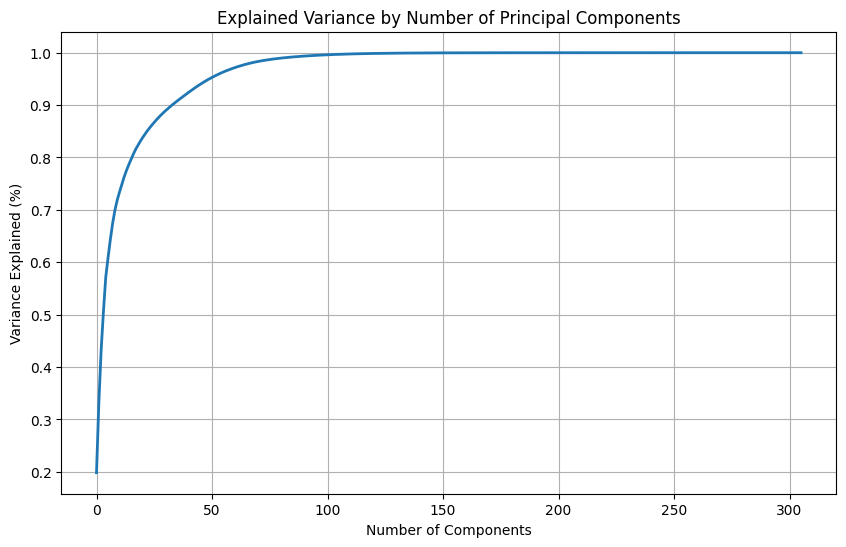

In [53]:
# Optional: Plot explained variance to decide number of components
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_), linewidth=2)
plt.xlabel('Number of Components')
plt.ylabel('Variance Explained (%)') # for each component
plt.title('Explained Variance by Number of Principal Components')
plt.grid()
plt.show()

In [54]:
n_components = np.argmax(np.cumsum(pca.explained_variance_ratio_) >= 0.95) + 1
print(f'Number of components explaining 99% of variance: {n_components}')

Number of components explaining 99% of variance: 50


In [55]:
pca = PCA(n_components= 200)
x_reduced = pca.fit_transform(x_scaled)

In [56]:
x_reduced.shape

(4238, 200)

In [58]:
X_train, X_test, y_train, y_test = train_test_split(x_reduced, y, test_size=0.2, random_state=42)

In [57]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x_reduced, y, test_size=0.2, random_state=42)
model = RandomForestRegressor()
model.fit(X_train, y_train)

# Make predictions and evaluate
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
print(f'R^2 Score: {r2}')

R^2 Score: 0.6756722874948167


In [ ]:

# Train a Support Vector Regression (SVR) model
svr = SVR(kernel='rbf', C=1.0, epsilon=0.1)  # You can tune these hyperparameters
svr.fit(X_train, y_train)

# Make predictions
y_pred = svr.predict(X_test)

# Evaluate the model using R^2
r2 = r2_score(y_test, y_pred)
print(f'R^2 Score: {r2}')

R^2 Score: 0.7747167359431071


In [ ]:
# Define the parameter grid
param_grid = {
    'C': [0.1, 1, 10, 100],
    'epsilon': [0.01, 0.1, 0.5, 1],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid']
}

# Create a GridSearchCV object
grid_search = GridSearchCV(SVR(), param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f'Best Parameters: {best_params}')
print(f'Best Cross-Validated R^2: {best_score}')

# Train the best model on the full training data
best_svr = grid_search.best_estimator_
best_svr.fit(X_train, y_train)

# Make predictions with the best model
y_pred_best = best_svr.predict(X_test)

# Evaluate the best model using R^2
best_r2 = r2_score(y_test, y_pred_best)
print(f'Best Model R^2 Score: {best_r2}')

KeyboardInterrupt: 